```
---
title: Election ETL
description: ETL Process on Malaysia’s 15th General Election Results
tags: [webscraping, scrapy]
---
```

## Objective

1. Extract Malaysia’s 15th General Election (PRU15) results
1. Transform using python
1. Load as flat file (csv)

## Extract

In [ ]:
import requests
!pip install scrapy
from scrapy import Selector
import re
import pandas as pd

In [ ]:
states = ['perlis', 'kedah', 'kelantan', 'terengganu', 'penang', 'perak', 'pahang', 'selangor', 'ft', 'negerisembilan', 'malacca', 'johor', 'sabah', 'sarawak']

all_parliament_codes = []
all_parliament_names = []
all_registered_voters = []
all_total_votes = []
all_winning_candidates = []
all_winning_parties = []
all_winning_majorities = []
all_winning_percentages = []

for s in states:
  # Get code snippet for only parliament in each state
  request = requests.get(f'https://election.thestar.com.my/{s}.html')
  text = request.text
  sel = Selector(text=text)
  parliament_code_snippet = sel.css('div#winnerListP').extract()
  
  sel2 = Selector(text=parliament_code_snippet[0])

  # Attribute - Parliament Code
  parliament_code = sel2.css('h4 > a::text').extract()
  all_parliament_codes.extend(parliament_code)

  # Attribute - Parliament Name
  parliament_name = sel2.css('h4 > a > span.n-name::text').extract()
  all_parliament_names.extend(parliament_name)

  # Attribute - Registered Voters
  voters_code_snippet = sel2.css('div.voters-vote > p').extract()
  registered_voters_snippet = [x for x in voters_code_snippet if x.find("Registered voters: ")>0]
  registered_voters = [text[30:text.index('<',30)] for text in registered_voters_snippet]
  all_registered_voters.extend(registered_voters)

  # Attribute - Total Votes
  candidates_code_snippet = sel2.css('div.panel').extract()
  total_voters = []
  for candidate_code_snippet in candidates_code_snippet:
    sel3 = Selector(text=candidate_code_snippet)
    total_voters_snippet = sel3.css('div.number-of-voters').extract()
    total_voter = 0
    for x in total_voters_snippet:
      total_voter += int(x[x.index('(')+1:x.index(')')].replace(',',''))
    total_voters.append(total_voter)
  all_total_votes.extend(total_voters)
  
  # Attribute - Winning Candidate
  candidates_code_snippet = sel2.css('div.panel').extract()
  winning_candidates = []
  for candidate_code_snippet in candidates_code_snippet:
    sel3 = Selector(text=candidate_code_snippet)
    candidates_name = sel3.css('p.name-candidate::text').extract()
    winning_candidate = candidates_name[0][0:candidates_name[0].index('(')-1]
    winning_candidates.append(winning_candidate)
  all_winning_candidates.extend(winning_candidates)

  # Attribute - Winning Party
  winners_code_snippet = sel2.xpath('//div[contains(@class, "panel-heading winner-")]').extract()
  winner_class = [re.findall('winner-[a-z]+', string) for string in winners_code_snippet]
  winning_parties = [x[0][7:] for x in winner_class]
  all_winning_parties.extend(winning_parties)

  # Attribute - Winning Majority
  majority_code_snippet = sel2.css('div.voters-vote > p').extract()
  majority_vote = [x for x in majority_code_snippet if x[3:11] == 'Majority']
  winning_majority = [text[21:text.index('<',21)] for text in majority_vote]
  all_winning_majorities.extend(winning_majority)

  # Attribute - Winning Percentage
  candidates_code_snippet = sel2.css('div.panel').extract()
  winning_percentages = []
  for candidate_code_snippet in candidates_code_snippet:
    sel3 = Selector(text=candidate_code_snippet)
    winning_percentage = sel3.css('span.voters-percent::text').extract()
    winning_percentages.append(winning_percentage[0])
  all_winning_percentages.extend(winning_percentages)

## Transform

In [ ]:
df = pd.DataFrame(data={'Parliament Name':all_parliament_names,
                        'Registered Voters':all_registered_voters,
                        'Total Voters':all_total_votes,
                        'Winning Candidate':all_winning_candidates,
                        'Winning Party':all_winning_parties,
                        'Winning Percentage':all_winning_percentages,
                        'Winning Majority':all_winning_majorities},
                  index=[pcode[0:-1] for pcode in all_parliament_codes])
df

,Parliament Name,Registered Voters,Total Voters,Winning Candidate,Winning Party,Winning Percentage,Winning Majority
P1,padang besar,"60,192",45288,Rushdan Rusmi,pas,40.3%,"12,514"
P2,kangar,"74,859",56200,Zakri Hassan,bersatu,32.8%,"9,192"
P3,arau,"60,876",46789,Shahidan Kassim,pas,51.7%,"23,216"
P4,langkawi,"66,777",47480,Mohd Suhaimi Abdullah,bersatu,38.1%,"13,518"
P5,jerlun,"67,601",52207,Abd Ghani Ahmad,pas,46.9%,"20,456"
...,...,...,...,...,...,...,...
P218,sibuti,"58,522",33916,Lukanisman Awang Sauni,pbb,37.8%,"11,745"
P219,miri,"143,229",78148,Chiew Choon Man,pkr,27.6%,"6,159"
P220,baram,"59,535",29783,Anyi Ngau,pdp,30.9%,"7,339"
P221,limbang,"41,999",19796,Hasbi Habibollah,pbb,35.5%,"9,998"


##### Data Cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222 entries, P1 to P222
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Parliament Name     222 non-null    object
 1   Registered Voters   222 non-null    object
 2   Total Voters        222 non-null    int64 
 3   Winning Candidate   222 non-null    object
 4   Winning Party       222 non-null    object
 5   Winning Percentage  222 non-null    object
 6   Winning Majority    222 non-null    object
dtypes: int64(1), object(6)
memory usage: 13.9+ KB


In [ ]:
df['Parliament Name'] = df['Parliament Name'].str.title()

In [ ]:
df['Registered Voters'] = df['Registered Voters'].str.replace(',', '').astype('int64')

In [ ]:
df['Winning Party'].unique()

array(['pas', 'bersatu', 'pkr', 'dap', 'umno', 'mic', 'amanah', 'muda',
       'mca', 'ind', 'kdm', 'warisan', 'upko', 'sabah', 'pbrs', 'pbs',
       'pbb', 'supp', 'prs', 'pbm', 'pdp'], dtype=object)

In [ ]:
def party_to_coalition(party):
  if party in ['pkr', 'dap', 'amanah', 'muda', 'upko']:
    return 'PH'
  elif party in ['bersatu', 'pas']:
    return 'PN'
  elif party in ['umno', 'mic', 'mca', 'pbrs']:
    return 'BN'
  elif party in ['kdm']:
    return 'KDM'
  elif party in ['warisan']:
    return 'WARISAN'
  elif party in ['sabah', 'pbs']:
    return 'GRS'
  elif party in ['pbb', 'supp', 'prs', 'pdp']:
    return 'GPS'
  elif party in ['pbm']:
    return 'PBM'
  elif party in ['ind']:
    return 'BEBAS'

In [ ]:
df['Winning Party'] = df['Winning Party'].apply(party_to_coalition)
df.rename(columns = {'Winning Party':'Winning Coalition'}, inplace = True)
df['Winning Coalition'].value_counts()

PH         82
PN         74
BN         30
GPS        23
GRS         6
WARISAN     3
BEBAS       2
KDM         1
PBM         1
Name: Winning Coalition, dtype: int64

In [ ]:
df['Winning Percentage'] = df['Winning Percentage'].str.replace('%', '').astype('float64')
df.rename(columns = {'Winning Percentage':'Winning Percentage (%)'}, inplace = True)

In [ ]:
df['Winning Majority'] = df['Winning Majority'].str.replace(',', '').astype('int64')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222 entries, P1 to P222
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Parliament Name         222 non-null    object 
 1   Registered Voters       222 non-null    int64  
 2   Total Voters            222 non-null    int64  
 3   Winning Candidate       222 non-null    object 
 4   Winning Coalition       222 non-null    object 
 5   Winning Percentage (%)  222 non-null    float64
 6   Winning Majority        222 non-null    int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 13.9+ KB


In [ ]:
df

,Parliament Name,Registered Voters,Total Voters,Winning Candidate,Winning Coalition,Winning Percentage (%),Winning Majority
P1,Padang Besar,60192,45288,Rushdan Rusmi,PN,40.3,12514
P2,Kangar,74859,56200,Zakri Hassan,PN,32.8,9192
P3,Arau,60876,46789,Shahidan Kassim,PN,51.7,23216
P4,Langkawi,66777,47480,Mohd Suhaimi Abdullah,PN,38.1,13518
P5,Jerlun,67601,52207,Abd Ghani Ahmad,PN,46.9,20456
...,...,...,...,...,...,...,...
P218,Sibuti,58522,33916,Lukanisman Awang Sauni,GPS,37.8,11745
P219,Miri,143229,78148,Chiew Choon Man,PH,27.6,6159
P220,Baram,59535,29783,Anyi Ngau,GPS,30.9,7339
P221,Limbang,41999,19796,Hasbi Habibollah,GPS,35.5,9998


##### Data Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

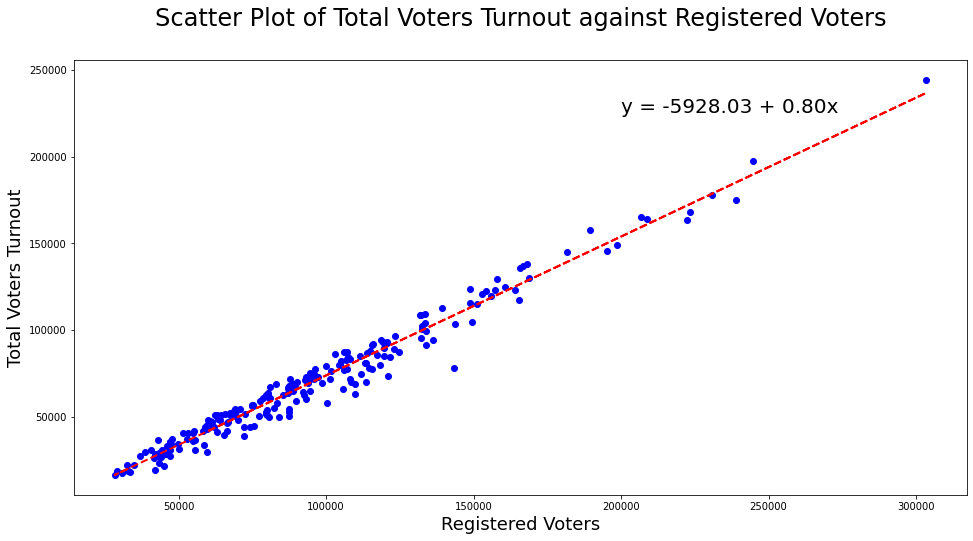

In [ ]:
df.plot(x='Registered Voters', y='Total Voters', color = 'blue', style='o', legend=False, figsize=(16,8))

a, b = np.polyfit(df['Registered Voters'], df['Total Voters'], 1)
plt.plot(df['Registered Voters'], a*df['Registered Voters']+b, color='red', linestyle='--', linewidth=2)
plt.text(200000, 225000, 'y = ' + f'{b:.2f} + {a:.2f}x', size=20)

plt.title("Scatter Plot of Total Voters Turnout against Registered Voters\n", fontdict={'fontsize': 24})
plt.xlabel('Registered Voters', fontsize=18)
plt.ylabel('Total Voters Turnout', fontsize=18)
plt.show()

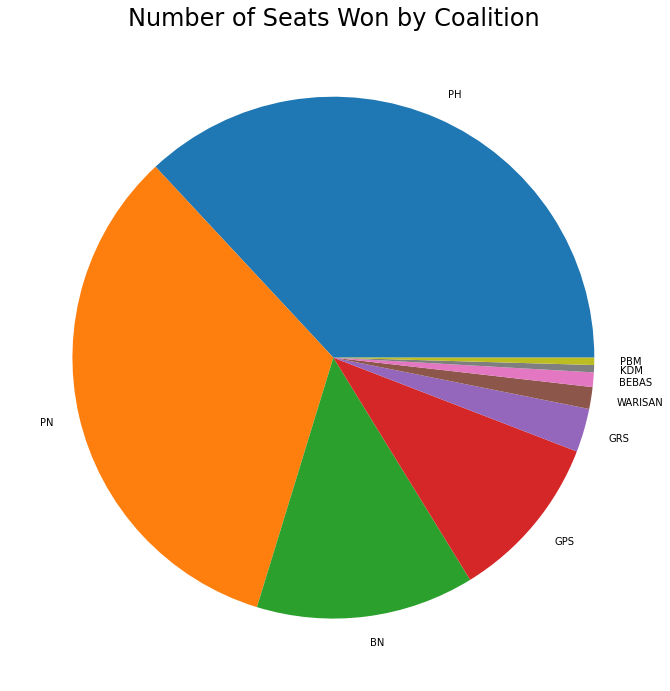

In [ ]:
df['Winning Coalition'].value_counts().plot(kind='pie', label='', figsize=(16,12))
plt.title("Number of Seats Won by Coalition", fontdict={'fontsize': 24})
plt.show()

Text(0.5, 1.0, 'Distribution of Winning Percentages')

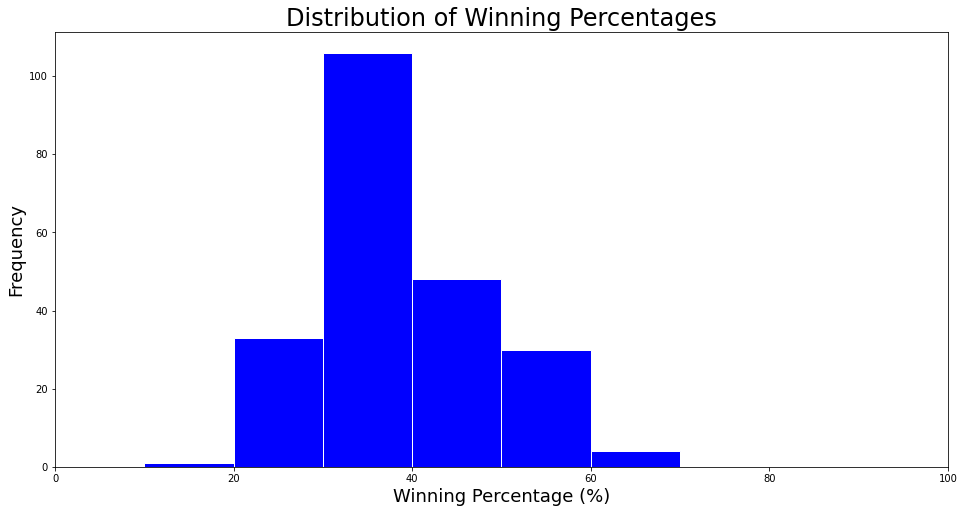

In [ ]:
df['Winning Percentage (%)'].plot(kind='hist', color='blue', edgecolor='white', bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], figsize=(16,8))
plt.xlim(xmin=0, xmax = 100)
plt.xlabel('Winning Percentage (%)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Distribution of Winning Percentages', fontdict={'fontsize': 24})

## Load

The final dataframe will look like:

In [ ]:
df

,Parliament Name,Registered Voters,Total Voters,Winning Candidate,Winning Coalition,Winning Percentage (%),Winning Majority
P1,Padang Besar,60192,45288,Rushdan Rusmi,PN,40.3,12514
P2,Kangar,74859,56200,Zakri Hassan,PN,32.8,9192
P3,Arau,60876,46789,Shahidan Kassim,PN,51.7,23216
P4,Langkawi,66777,47480,Mohd Suhaimi Abdullah,PN,38.1,13518
P5,Jerlun,67601,52207,Abd Ghani Ahmad,PN,46.9,20456
...,...,...,...,...,...,...,...
P218,Sibuti,58522,33916,Lukanisman Awang Sauni,GPS,37.8,11745
P219,Miri,143229,78148,Chiew Choon Man,PH,27.6,6159
P220,Baram,59535,29783,Anyi Ngau,GPS,30.9,7339
P221,Limbang,41999,19796,Hasbi Habibollah,GPS,35.5,9998


Save the dataframe into a .csv file.

In [ ]:
df.to_csv('data.csv')